In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [27]:
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN,self).__init__()
        self.conv1=nn.Conv2d(1,32,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
        self.fc1=nn.Linear(64*16*16,512)
        self.fc2=nn.Linear(512,7)
        
    def forward(self,x):
        x=self.pool(torch.relu(self.conv1(x)))
        x=self.pool(torch.relu(self.conv2(x)))
        x=x.view(x.size(0),-1)
        x=torch.relu(self.fc1(x))
        x=self.fc2(x)
        return x     

In [28]:
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [29]:
train_dataset=datasets.ImageFolder(r'/Users/joshna/Desktop/Data/train',transform=transform)
test_dataset=datasets.ImageFolder(r'/Users/joshna/Desktop/Data/test',transform=transform)
print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 28709
Test dataset size: 7178


In [30]:
num_epochs=10
train_batch_size=32
test_batch_size=32

train_loader=DataLoader(train_dataset,batch_size=train_batch_size,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=test_batch_size,shuffle=True)

model=EmotionCNN()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss=0.0
    
    for inputs,labels in tqdm(train_loader,desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs,labels=inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        outputs=model(inputs)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss:{running_loss / len(train_loader)}")

model.eval()
all_preds=[]
all_labels=[]

with torch.no_grad():
    for inputs,labels in tqdm(test_loader,desc="Evaluating"):
        inputs,labels=inputs.to(device),labels.to(device)
        outputs=model(inputs)
        _,preds=torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Epoch 1/10: 100%|█████████████████████████████| 898/898 [03:56<00:00,  3.79it/s]


Epoch 1/10, Loss:1.6574764827842967


Epoch 2/10: 100%|█████████████████████████████| 898/898 [03:40<00:00,  4.08it/s]


Epoch 2/10, Loss:1.4613190591999046


Epoch 3/10: 100%|█████████████████████████████| 898/898 [03:44<00:00,  4.00it/s]


Epoch 3/10, Loss:1.3215052276385122


Epoch 4/10: 100%|█████████████████████████████| 898/898 [03:47<00:00,  3.95it/s]


Epoch 4/10, Loss:1.1868077167423903


Epoch 5/10: 100%|█████████████████████████████| 898/898 [03:40<00:00,  4.07it/s]


Epoch 5/10, Loss:1.0394132323148255


Epoch 6/10: 100%|█████████████████████████████| 898/898 [03:39<00:00,  4.08it/s]


Epoch 6/10, Loss:0.8675948577893603


Epoch 7/10: 100%|█████████████████████████████| 898/898 [03:46<00:00,  3.97it/s]


Epoch 7/10, Loss:0.6891441571553194


Epoch 8/10: 100%|█████████████████████████████| 898/898 [03:58<00:00,  3.77it/s]


Epoch 8/10, Loss:0.5025137892046856


Epoch 9/10: 100%|█████████████████████████████| 898/898 [04:33<00:00,  3.28it/s]


Epoch 9/10, Loss:0.3518698141061782


Epoch 10/10: 100%|████████████████████████████| 898/898 [05:14<00:00,  2.86it/s]


Epoch 10/10, Loss:0.23396643017209187


Evaluating: 100%|█████████████████████████████| 225/225 [00:26<00:00,  8.56it/s]


In [31]:
accuracy=accuracy_score(all_labels,all_preds)
print(f"Accuracy:{accuracy}")

print("Classification Report:")
print(classification_report(all_labels,all_preds))

Accuracy:0.48620785734187794
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.39      0.37       958
           1       0.60      0.37      0.46       111
           2       0.34      0.44      0.38      1024
           3       0.71      0.63      0.66      1774
           4       0.47      0.38      0.42      1233
           5       0.37      0.40      0.39      1247
           6       0.67      0.65      0.66       831

    accuracy                           0.49      7178
   macro avg       0.50      0.47      0.48      7178
weighted avg       0.50      0.49      0.49      7178



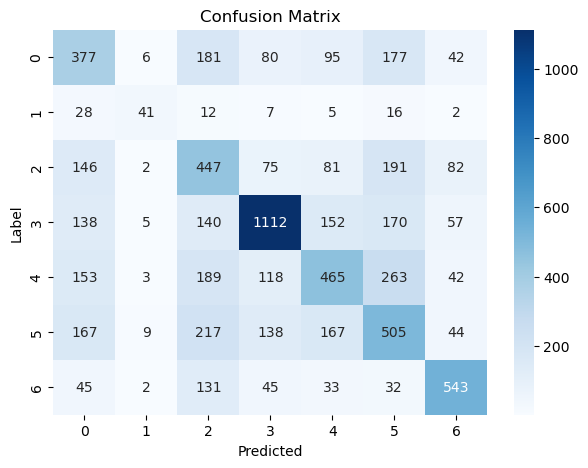

In [33]:
cm=confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='g',cmap='Blues',xticklabels=range(7),yticklabels=range(7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Label')
plt.show()